In [29]:
import data_loader
import pandas as pd
import seaborn as sb
import numpy as np
init_train = data_loader.load_train_data("../data/adult.data", valid_rate=1, is_df = "True")
test = data_loader.load_test_data("../data/adult.test", is_df = "True")
train = init_train[1]

### Replacing all column indices with attribute names

We printed the dataframe and we noticed that column values were numbers, so we replaced with the attribute names for better readability.

In [30]:
col_map = ["age", "workclass", "final_weight", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "cap_gain", "cap_loss", "hrs_p_week","country","income"]
train.columns = col_map

### Missing Values
We now noticed that the dataset had missing values and we counted the no of missing values for every column. After finding out the columns that missing values, we removed those corresponding rows. It was approximately around 2000 and did not alter the dataset much.

In [31]:
for column in train.columns:
    su = (train[column] == ' ?').sum()
    if su > 0:
        print("Column: ",column, " Count: ",su)
train = train[((train.country != ' ?') & (train.workclass != ' ?') & (train.occupation != ' ?'))]

Column:  workclass  Count:  1836
Column:  occupation  Count:  1843
Column:  country  Count:  583


### Results Remapping

Income column is the result column. We have essentially remapped the two output values (<=50K and >50K) to binary values (0 and 1),# and put them in a new numpy array

In [32]:
train['income'] = train['income'].map({ " <=50K": 0, " >50K": 1})
#Results = np.copy(train['income'].values)
#train.drop(columns="income",inplace=True)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Data Visualization

Help on package seaborn:

NAME
    seaborn - # Capture the original matplotlib rcParams

PACKAGE CONTENTS
    algorithms
    apionly
    axisgrid
    categorical
    cm
    colors (package)
    conftest
    distributions
    external (package)
    linearmodels
    matrix
    miscplot
    palettes
    rcmod
    regression
    relational
    tests (package)
    timeseries
    utils
    widgets

DATA
    crayons = {'Almond': '#EFDECD', 'Antique Brass': '#CD9575', 'Apricot':...
    xkcd_rgb = {'acid green': '#8ffe09', 'adobe': '#bd6c48', 'algae': '#54...

VERSION
    0.9.0

FILE
    /usr/lib/python3.7/site-packages/seaborn-0.9.0-py3.7.egg/seaborn/__init__.py




TypeError: unsupported operand type(s) for +: 'int' and 'str'

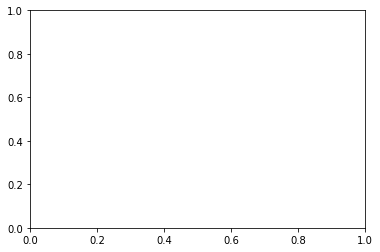

In [34]:
help(sb)
sb.distplot(train, hist=True, label=train.education)

### Feature Cleaning:

We analyzed the dataset and found that the columns education and education number had a one-to-one mapping. Thus We have extracted this one-to-one mapping relationship into a dictionary called edu_map and removed the education column from the dataset.

In [ ]:
temp = train[['education','education_num']]
edu_map = temp.drop_duplicates().set_index('education_num').to_dict()['education']
train.drop(columns="education", inplace=True)

In [ ]:
print(train.columns)

In [ ]:
for column in train.columns:
    su = (train[column] == ' ?').sum()
    if su > 0:
        print("Column: ",column, " Count: ",su)

In [ ]:
#train.drop(columns=['workclass','occupation','country'], )
new_train = train[((train.country != ' ?') & (train.workclass != ' ?') & (train.occupation != ' ?'))]
for column in new_train.columns:
    su = (new_train[column] == ' ?').sum()
    if su > 0:
        print("Column: ",column, " Sum: ",su)

In [ ]:
print(new_train.corr())